# Misprediction diagnoser 

Our goal is to check whether a prediction made by transformer based model is correct or not. We will use the following steps to achieve this goal:

    1. Find the important attention heads for the prediction 
    2. Use identified attention heads to diagnose the prediction by evaluating if the attention weights/attribution scores are locate within the correct region of the input code. 
       1. If not, consider as misprediction
       2. If yes, consider as correct prediction. 
    3. However we need more than one attention head to diagnose the prediction. 

### 1. Find the important attention heads for the prediction

How to identify important heads?
1. ONly one category of syntax. Check if the attention weights are significant between the correct and incorrect region.

The problem of this approach is that it only considers one kind of syntax. This syntax may not in some instacens. 

2. Multiple categories of syntax, and use the frequcy of significant attention weights to indicate the most sensitive heads. For example, if we evaluate 9 syntaxes, and if some heads have 9 significant heads, then we can consider this head as the most sensitive head.

For this approach we might need a voting mechanism as some syntax may within the correct region, but some syntax may not. Thus, we need to consider the how to deal with multiple syntaxes on multiple heads. Furthermore, we may also need to consider the importance of each syntax. Some syntax might be more important than others.

In [1]:
import pickle
import numpy as np
from scipy.stats import ttest_ind
# import pandas
import pandas as pd
# import matplotlib
import matplotlib.pyplot as plt
# import seaborn
import seaborn as sns
%matplotlib inline
from matplotlib.pyplot import figure
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.metrics import classification_report

In [2]:
instance_correct = pickle.load(open("results/syntax_attention_instance_correct5.pkl", "rb"))
instance_mispredict = pickle.load(open("results/syntax_attention_instance_misprediction5.pkl", "rb"))
len(instance_correct), len(instance_mispredict)

(27825, 7118)

In [3]:
syntax_type_list = list(instance_correct[0].keys())

In [49]:
syntax_type_list

['annotation',
 'basictype',
 'boolean',
 'decimalinteger',
 'identifier',
 'keyword',
 'modifier',
 'operator',
 'separator',
 'null',
 'string',
 'decimalfloatingpoint']

In [ ]:
instance_mispredict[0].keys()

dict_keys(['annotation', 'basictype', 'boolean', 'decimalinteger', 'identifier', 'keyword', 'modifier', 'operator', 'separator', 'null', 'string', 'decimalfloatingpoint'])

### Split data into Important head identification and Misprediction diagnoser(70% and 30%)

In [4]:
from sklearn.model_selection import train_test_split

len_correct = len(instance_correct)

instance_correct_IDF, instance_correct_Diagnose = train_test_split(instance_correct, test_size=0.3, random_state=42)

instance_mispredict_IDF, instance_mispredict_Diagnose = train_test_split(instance_mispredict, test_size=0.3, random_state=42)

len(instance_correct_IDF), len(instance_correct_Diagnose), len(instance_mispredict_IDF), len(instance_mispredict_Diagnose)

(19477, 8348, 4982, 2136)

## Identify important heads

In [ ]:
len(instance_correct[0].keys()), len(instance_mispredict[0].keys())

(12, 12)

In total, there are 12 syntaxes. We will use the following steps to identify the important heads:

    1. For each syntax, we will use the attention weights to evaluate if the attention weights are significant between the correct and incorrect region. 
    2. If the attention weights are significant, we will consider this head as important head. 
    3. We will use the frequency of important heads to identify the most important heads.

For now we will give equal weight to each syntax. In the future, we can consider the importance of each syntax.


In [ ]:
import numpy as np
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [ ]:
import numpy as np
import scipy.stats as st

# #define sample data
# data = [12, 12, 13, 13, 15, 16, 17, 22, 23, 25, 26, 27, 28, 28, 29]

# #create 95% confidence interval for population mean weight
# a = st.t.interval(alpha=0.95, df=len(data)-1, loc=np.mean(data), scale=st.sem(data)) 

In [5]:
def get_syntax_attention(instance_correct_IDF, instance_mispredict_IDF, syntax_type):
    corerct_temp_list = []
    mispredict_temp_list = []

    for i in range(len(instance_correct_IDF)):
        temp = np.array(instance_correct_IDF[i][syntax_type])
        if temp.shape[0] == 1:
            corerct_temp_list.append(np.squeeze(temp, axis =0))
            
    for i in range(len(instance_mispredict_IDF)):
        temp = np.array(instance_mispredict_IDF[i][syntax_type])
        if temp.shape[0] == 1:
            mispredict_temp_list.append(np.squeeze(temp, axis =0))
            
    return corerct_temp_list, mispredict_temp_list

In [6]:
def get_syntax_head_level_attribution_ttest_result(instance_correct, instance_mispredict):
    annotation_correct = instance_correct
    annotation_mispredict = instance_mispredict
    
    top_correct_annotation = []
    for instance in annotation_correct:
        top_correct_annotation.append(np.max(instance, axis=2))
        
    top_mispredict_annotation = []
    for instance in annotation_mispredict:
        top_mispredict_annotation.append(np.max(instance, axis=2))
        
    top_mispredict_annotation = np.array(top_mispredict_annotation)
    top_correct_annotation = np.array(top_correct_annotation)

    # convert top_mispredict_annotation from length, layers, heads to layers, heads, length

    coverted_top_mispredict_annotation = np.transpose(top_mispredict_annotation, (1, 2, 0))
    coverted_top_correct_annotation = np.transpose(top_correct_annotation, (1, 2, 0))

    p_value_distribution = []
    significant_head_number = 0

    for layer in range(coverted_top_mispredict_annotation.shape[0]):
        layer_attronutions = []
        for head in range(coverted_top_mispredict_annotation.shape[1]):
            # get 95% confidence interval
            temp_data = coverted_top_correct_annotation[layer][head]
            correct_data_mean = np.mean(temp_data)
            correct_data_std = np.std(temp_data)
            correct_lower = correct_data_mean - 1.96 * correct_data_std
            correct_upper = correct_data_mean + 1.96 * correct_data_std
            # correct_lower, correct_upper = st.t.interval(alpha=0.95, df=len(temp_data)-1, loc=np.mean(temp_data), scale=st.sem(temp_data)) 
            temp_data_2 = coverted_top_mispredict_annotation[layer][head]
            mispredict_data_mean = np.mean(temp_data_2)
            mispredict_data_std = np.std(temp_data_2)
            mispredict_lower = mispredict_data_mean - 1.96 * mispredict_data_std
            mispredict_upper = mispredict_data_mean + 1.96 * mispredict_data_std
            # mispred_lower, mispred_upper = st.t.interval(alpha=0.95, df=len(temp_data_2)-1, loc=np.mean(temp_data_2), scale=st.sem(temp_data_2))
            
            # mispred_mean, mispred_lower, mispred_upper = mean_confidence_interval(coverted_top_mispredict_annotation[layer][head])
            # get data between the lower and upper bound
            P95_correct_data = [x for x in coverted_top_correct_annotation[layer][head] if x >= correct_lower and x <= correct_upper]
            P95_mispred_data = [x for x in coverted_top_mispredict_annotation[layer][head] if x >= mispredict_lower and x <= mispredict_upper]
            
            p_value = ttest_ind(P95_correct_data, P95_mispred_data).pvalue
            if p_value < 0.05:
                layer_attronutions.append(0.05)
                significant_head_number += 1
            else:
                layer_attronutions.append(1)
        p_value_distribution.append(layer_attronutions)
        
    return p_value_distribution, significant_head_number

In [7]:
p_value_dict = {}
significant_head_number_dict = {}

for syntax_type in syntax_type_list:
    corerct_temp_list, mispredict_temp_list = get_syntax_attention(instance_correct_IDF, instance_mispredict_IDF, syntax_type)
    p_value_dict[syntax_type], significant_head_number_dict[syntax_type]= get_syntax_head_level_attribution_ttest_result(corerct_temp_list, mispredict_temp_list)


In [ ]:
print(len(p_value_dict.keys()))
p_value_dict.keys()

12


dict_keys(['annotation', 'basictype', 'boolean', 'decimalinteger', 'identifier', 'keyword', 'modifier', 'operator', 'separator', 'null', 'string', 'decimalfloatingpoint'])

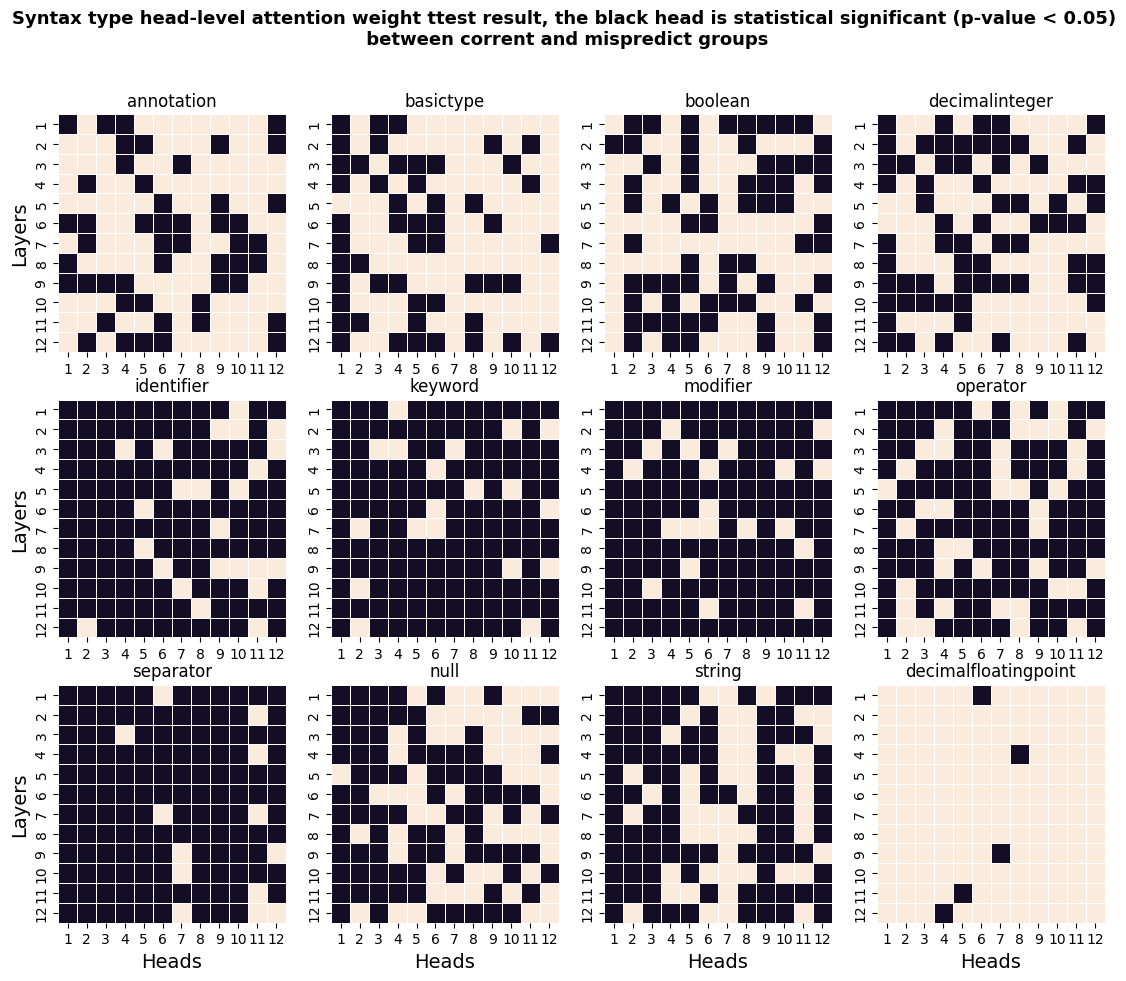

In [8]:
fig, axs = plt.subplots(3, 4)
# set title for whole figure
fig.suptitle('Syntax type head-level attention weight ttest result, the black head is statistical significant (p-value < 0.05)\n between corrent and mispredict groups', fontsize=13, fontweight='bold')

for i in range(3):
    for j in range(4):
        syntax_type = syntax_type_list[i*4+j]
        p_value_distribution = p_value_dict[syntax_type]
        p_value_distribution = np.array(p_value_distribution)
        p_value_distribution = np.transpose(p_value_distribution, (1, 0))
        # axs[i, j].imshow(p_value_distribution, cmap='hot', interpolation='nearest')
        axs[i, j] = sns.heatmap(p_value_distribution, cbar=False, linewidth=0.5, ax=axs[i, j], vmin=0, vmax=1)
        axs[i, j].set_title(syntax_type)
        # add 1 to xticks and yticks
        axs[i, j].set_xticks(np.arange(0, 12, 1) + 0.5, np.arange(1, 13, 1))
        axs[i, j].set_yticks(np.arange(0, 12, 1) + 0.5, np.arange(1, 13, 1))

# set xlabel for bottom row of subplots
numb = 0
for ax in axs.flat:
    # 
    numb += 1
    if numb > 8:
        ax.set(xlabel='Heads')
        ax.xaxis.label.set_size(14)
# set ylabel for left column of subplots
    if numb == 1 or numb == 5 or numb == 9:
        ax.set(ylabel='Layers')
        ax.yaxis.label.set_size(14)

# change figure size
fig.set_size_inches(13.5, 10.5)
plt.show()

In [9]:
significant_head_record = [[[] for col in range(12)] for row in range(12)]

for syntax_type in list(instance_correct[0].keys()):
    corerct_temp_list, mispredict_temp_list = get_syntax_attention(instance_correct_IDF, instance_mispredict_IDF, syntax_type)

In [14]:
interesting_syntax_type = ['identifier', 'keyword', 'modifier', 'operator', 'separator', 'string']
# interesting_syntax_type = syntax_type_list

In [15]:
def calculate_significant_head_number(p_value_distribution):
    significant_head_record = [[[] for col in range(12)] for row in range(12)]
    for syntax in interesting_syntax_type:
        for layer in range(len(p_value_distribution[syntax])):
            for head in range(len(p_value_distribution[syntax][layer])):
                if p_value_distribution[syntax][layer][head] == 0.05:
                    significant_head_record[layer][head].append(syntax)
                    
    return significant_head_record

In [16]:
significant_head_record = calculate_significant_head_number(p_value_dict)

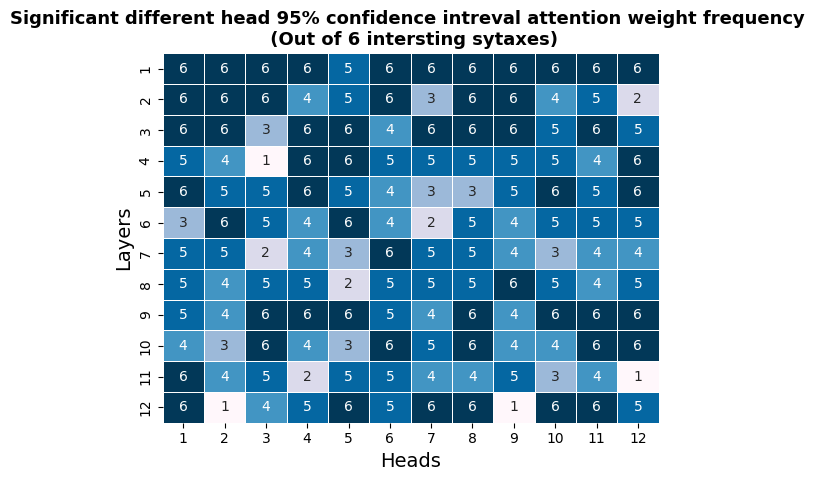

In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
head_significant_frequency = [[0 for col in range(12)] for row in range(12)]

for layer in range(len(significant_head_record)):
    for head in range(len(significant_head_record[layer])):
        head_significant_frequency[layer][head] = len(significant_head_record[layer][head])

ax = sns.heatmap(head_significant_frequency, linewidth=0.5, annot=True, cbar=False, fmt='d', cmap='PuBu', vmax=len(interesting_syntax_type))
plt.title('Significant different head 95% confidence intreval attention weight frequency \n (Out of {} intersting sytaxes)'.format(len(interesting_syntax_type)), fontsize=13, fontweight='bold')
# add one to the x axis
plt.xticks(np.arange(0, 12, 1) + 0.5, np.arange(1, 13, 1))
# do same thing for y axis
plt.yticks(np.arange(0, 12, 1) + 0.5, np.arange(1, 13, 1))

plt.xlabel('Heads', fontsize=14)
plt.ylabel('Layers', fontsize=14)
plt.show()

From above chart, we can see that some heads shows more significant attention weights difference between the correct and incorrect region. Especially for the Layer 1 Head 12, Layer 2 Head 4, 10 and etc. They shows significant difference between the correct and incorrect region on all 12 syntaxes. Thus, we can consider these heads as important heads.

In [19]:
most_significant_head = []
for layer in range(len(head_significant_frequency)):
    for head in range(len(head_significant_frequency[layer])):
        if head_significant_frequency[layer][head] >= 6:
            most_significant_head.append((layer, head))
print('Number of most significant heads:', len(most_significant_head))
print("(layer, head))")
print(most_significant_head)

Number of most significant heads: 55
(layer, head))
[(0, 0), (0, 1), (0, 2), (0, 3), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (1, 0), (1, 1), (1, 2), (1, 5), (1, 7), (1, 8), (2, 0), (2, 1), (2, 3), (2, 4), (2, 6), (2, 7), (2, 8), (2, 10), (3, 3), (3, 4), (3, 11), (4, 0), (4, 3), (4, 9), (4, 11), (5, 1), (5, 4), (6, 5), (7, 8), (8, 2), (8, 3), (8, 4), (8, 7), (8, 9), (8, 10), (8, 11), (9, 2), (9, 5), (9, 7), (9, 10), (9, 11), (10, 0), (11, 0), (11, 4), (11, 6), (11, 7), (11, 9), (11, 10)]


In [111]:
most_significant_head = most_significant_head[0:16]

In [21]:
def get_syntax_significant_head_distributions(instance_correct, instance_mispredict, most_significant_head):
    annotation_correct = instance_correct
    annotation_mispredict = instance_mispredict
    
    top_correct_annotation = []
    for instance in annotation_correct:
        top_correct_annotation.append(np.max(instance, axis=2))
        
    top_mispredict_annotation = []
    for instance in annotation_mispredict:
        top_mispredict_annotation.append(np.max(instance, axis=2))
        
    top_mispredict_annotation = np.array(top_mispredict_annotation)
    top_correct_annotation = np.array(top_correct_annotation)

    # convert top_mispredict_annotation from length, layers, heads to layers, heads, length

    coverted_top_mispredict_annotation = np.transpose(top_mispredict_annotation, (1, 2, 0))
    coverted_top_correct_annotation = np.transpose(top_correct_annotation, (1, 2, 0))
    
    correct_heads_attention = []
    mispred_heads_attention = []
    
    
    for layer, head in most_significant_head:
        # get 95% confidence interval
        temp_data = coverted_top_correct_annotation[layer][head]
        correct_data_mean = np.mean(temp_data)
        correct_data_std = np.std(temp_data)
        correct_lower = correct_data_mean - 1.96 * correct_data_std
        correct_upper = correct_data_mean + 1.96 * correct_data_std
        # correct_lower, correct_upper = st.t.interval(alpha=0.95, df=len(temp_data)-1, loc=np.mean(temp_data), scale=st.sem(temp_data)) 
        # correct_mean, correct_lower, correct_upper = mean_confidence_interval(coverted_top_correct_annotation[layer][head])
        temp_data_2 = coverted_top_mispredict_annotation[layer][head]
        mispredict_data_mean = np.mean(temp_data_2)
        mispredict_data_std = np.std(temp_data_2)
        mispredict_lower = mispredict_data_mean - 1.96 * mispredict_data_std
        mispredict_upper = mispredict_data_mean + 1.96 * mispredict_data_std
        # mispred_lower, mispred_upper = st.t.interval(alpha=0.95, df=len(temp_data_2)-1, loc=np.mean(temp_data_2), scale=st.sem(temp_data_2))
        # mispred_mean, mispred_lower, mispred_upper = mean_confidence_interval(coverted_top_mispredict_annotation[layer][head])
        
        # get data between the lower and upper bound
        P95_correct_data = [x for x in coverted_top_correct_annotation[layer][head] if x >= correct_lower and x <= correct_upper]
        P95_mispred_data = [x for x in coverted_top_mispredict_annotation[layer][head] if x >= mispredict_lower and x <= mispredict_upper]

        correct_heads_attention.append(P95_correct_data)
        mispred_heads_attention.append(P95_mispred_data)
        
    return correct_heads_attention, mispred_heads_attention

In [22]:
# Plot the boxplot of the most significant head attention weight distribution
corerct_temp_list, mispredict_temp_list = get_syntax_attention(instance_correct_IDF, instance_mispredict_IDF, syntax_type)
correct_heads_attention, mispred_heads_attention = get_syntax_significant_head_distributions(corerct_temp_list,
                                                                                             mispredict_temp_list,
                                                                                             most_significant_head)

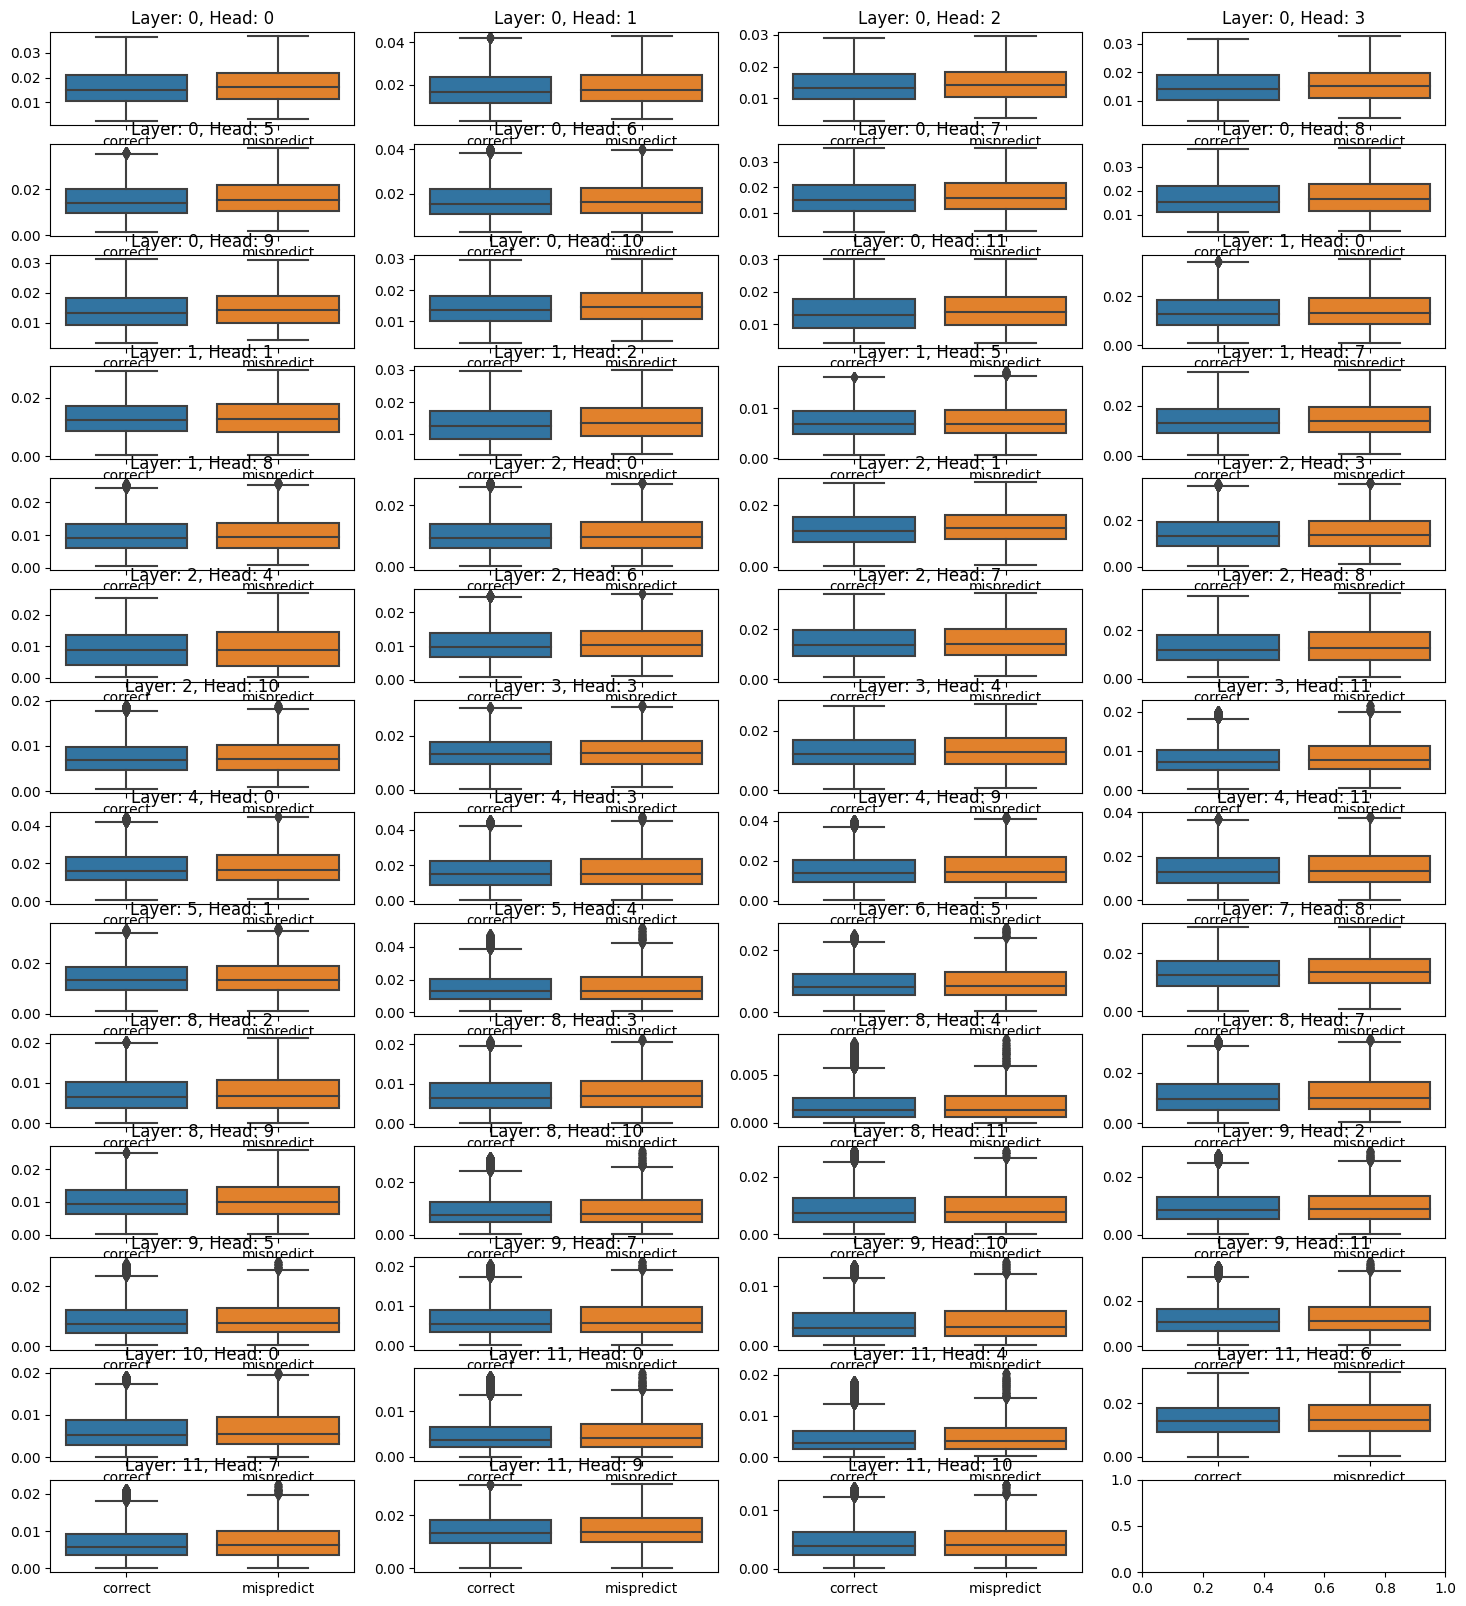

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# plot all most significant head attention weight distribution
# each row plot 4 paris 
syntax_type = "operator"

corerct_temp_list, mispredict_temp_list = get_syntax_attention(instance_correct_IDF, instance_mispredict_IDF, syntax_type)
correct_heads_attention, mispred_heads_attention = get_syntax_significant_head_distributions(corerct_temp_list,
                                                                                             mispredict_temp_list,
                                                                                             most_significant_head)


fig, axs = plt.subplots(len(correct_heads_attention)//4 + 1, 4, figsize=(18, 20))
# fig.suptitle('Significant head attribution comparison result', fontsize=13, fontweight='bold')

for i in range(len(correct_heads_attention)):
    a = correct_heads_attention[i]
    b = mispred_heads_attention[i]
    dict = {'prediction': ['correct']*len(a) + ['mispredict']*len(b), 'attention_weight': a + b}
    df = pd.DataFrame(dict)
    sns.boxplot(x="prediction", y="attention_weight", data=df, ax=axs[i//4][i%4])
    axs[i//4][i%4].set_title('Layer: {}, Head: {}'.format(most_significant_head[i][0], most_significant_head[i][1]))
    # remove x label for all but the last row
    axs[i//4][i%4].set_xlabel('')
    # remove y label for all but the first column
    axs[i//4][i%4].set_ylabel('')
    # remove x ticks for all but the last row
    # axs[i//4][i%4].set_xticks([])

From above charts, we can observe even though these 19 heads are most sensetive heads, there are still overlap values between the correct and incorrect region. Thus, we need to use multiple heads to diagnose the prediction.

Now, we have 19 most sensetive heads, and we have 12 syntaxes (Not all syntaxes neccessary in one code snippet). 

19 heads * 12 syntaxes = 228

For now, we give each syntax equal weight.

no matter how many syntaxes are in the code snippet, we will use 19 heads to diagnose the prediction.

If more than half of the heads are in the correct region, we will consider this prediction as correct prediction. Otherwise, we will consider this prediction as misprediction.

## Misprediction Diagnose

In [ ]:
def get_syntax_significant_head_upper_lower_bound(instance_correct, instance_mispredict, most_significant_head):
    annotation_correct = instance_correct
    annotation_mispredict = instance_mispredict
    
    top_correct_annotation = []
    for instance in annotation_correct:
        top_correct_annotation.append(np.max(instance, axis=2))
        
    top_mispredict_annotation = []
    for instance in annotation_mispredict:
        top_mispredict_annotation.append(np.max(instance, axis=2))
        
    top_mispredict_annotation = np.array(top_mispredict_annotation)
    top_correct_annotation = np.array(top_correct_annotation)

    # convert top_mispredict_annotation from length, layers, heads to layers, heads, length

    coverted_top_mispredict_annotation = np.transpose(top_mispredict_annotation, (1, 2, 0))
    coverted_top_correct_annotation = np.transpose(top_correct_annotation, (1, 2, 0))
    
    correct_heads_attention = []
    mispred_heads_attention = []
    
    upper_lower_bounds = {}
    
    
    for layer, head in most_significant_head:
        # get 95% confidence interval
        temp_data = coverted_top_correct_annotation[layer][head]
        correct_data_mean = np.mean(temp_data)
        correct_data_std = np.std(temp_data)
        correct_lower = correct_data_mean - 1.96 * correct_data_std
        correct_upper = correct_data_mean + 1.96 * correct_data_std
        # correct_lower, correct_upper = st.t.interval(alpha=0.95, df=len(temp_data)-1, loc=np.mean(temp_data), scale=st.sem(temp_data))
        within_list = [x for x in coverted_top_correct_annotation[layer][head] if x >= correct_lower and x <= correct_upper]
        # print("Covered percentage: ", len(within_list)/len(coverted_top_correct_annotation[layer][head]))
        # correct_mean, correct_lower, correct_upper = mean_confidence_interval(coverted_top_correct_annotation[layer][head], confidence=0.98)
        temp_data_2 = coverted_top_mispredict_annotation[layer][head]
        # temp_data_2 = coverted_top_mispredict_annotation[layer][head]
        mispredict_data_mean = np.mean(temp_data_2)
        mispredict_data_std = np.std(temp_data_2)
        mispredict_lower = mispredict_data_mean - 1.96 * mispredict_data_std
        mispredict_upper = mispredict_data_mean + 1.96 * mispredict_data_std
        # mispred_lower, mispred_upper = st.t.interval(alpha=0.8, df=len(temp_data_2)-1, loc=np.mean(temp_data_2), scale=st.sem(temp_data_2))
        # mispred_mean, mispred_lower, mispred_upper = mean_confidence_interval(coverted_top_mispredict_annotation[layer][head], confidence=0.95)
        
        upper_lower_bounds[(layer, head)] = (correct_lower, correct_upper, mispredict_lower, mispredict_upper)
    return upper_lower_bounds

In [ ]:
# get upper and lower bound of the attention weight for each head in each layer for each syntax type 
check_book = {} 

for syntax_type in list(instance_correct[0].keys()):
    corerct_temp_list, mispredict_temp_list = get_syntax_attention(instance_correct_IDF, instance_mispredict_IDF, syntax_type)
    upper_lower_bounds = get_syntax_significant_head_upper_lower_bound(corerct_temp_list,
                                                                        mispredict_temp_list,
                                                                        most_significant_head)
    check_book[syntax_type] = upper_lower_bounds

#### Now we can start check if a prediction is correct or not by checking if the attention weight is in the 95% confidence interval of the correct prediction

In [ ]:
len(instance_correct_Diagnose), len(instance_mispredict_Diagnose)

(8348, 2136)

In [ ]:
for syntax_type in list(instance_correct_Diagnose[0].keys()):
    if np.array(instance_correct_Diagnose[0][syntax_type]).shape[0] == 1:
        print(syntax_type)

identifier
keyword
operator
separator
null
string


The first testing code snippet contains above 8 sytaxes, and we will use the 19 most sensetive heads to diagnose the prediction of these 8 syntaxes for this code snippet. Thus, there are 19 * 8 = 152 attention weights to check.

In [ ]:
def check_head_values(instance, check_book, most_significant_head):
    available_syntax = []
    for syntax_type in list(instance.keys()):
        if np.array(instance[syntax_type]).shape[0] == 1:
            available_syntax.append(syntax_type)
    
    within_bound_check = 0
    Outof_bound_check = 0
    
    for layer, head in most_significant_head:
        for syntax_type in available_syntax:
            attention_weights = np.array(instance[syntax_type]).squeeze(axis=0)
            max_attention = np.max(attention_weights, axis=2)
            
            if max_attention[layer][head] >= check_book[syntax_type][(layer, head)][0] and max_attention[layer][head] <= check_book[syntax_type][(layer, head)][1]:
                within_bound_check += 1
            else:
                Outof_bound_check += 1
        
    return within_bound_check, Outof_bound_check

In [88]:
within = []
out = []

for i in range(len(instance_correct_Diagnose)):
    within_bound_check, Outof_bound_check = check_head_values(instance_correct_Diagnose[i], check_book, most_significant_head)
    within.append(within_bound_check)
    out.append(Outof_bound_check)
    
for i in range(len(instance_mispredict_Diagnose)):
    within_bound_check, Outof_bound_check = check_head_values(instance_mispredict_Diagnose[i], check_book, most_significant_head)
    within.append(within_bound_check)
    out.append(Outof_bound_check)
    
dict = {"Within_count": within, "Out_count": out, "True_value": [1]*len(instance_correct_Diagnose) + [0]*len(instance_mispredict_Diagnose)}

result_df = pd.DataFrame(dict)



print("The frequency of unique values in diagnose_values array is: ")

In [91]:
result_df['total'] = result_df['Within_count'] + result_df['Out_count']
result_df['Within_percentage'] = result_df['Within_count']/result_df['total']

result_df['diagnose'] = result_df['Within_percentage'] > 0.5
result_df['diagnose'] = result_df['diagnose'].astype(int)

In [93]:
result_df.head()

,Within_count,Out_count,True_value,total,Within_percentage,diagnose
0,70,2,1,72,0.972222,1
1,43,17,1,60,0.716667,1
2,108,0,1,108,1.000000,1
3,84,0,1,84,1.000000,1
4,60,0,1,60,1.000000,1


In [92]:
print(classification_report(result_df['True_value'], result_df['diagnose']))

              precision    recall  f1-score   support

           0       0.15      0.02      0.03      2136
           1       0.80      0.98      0.88      8348

    accuracy                           0.78     10484
   macro avg       0.47      0.50      0.45     10484
weighted avg       0.66      0.78      0.70     10484

